<a href="https://colab.research.google.com/github/davidfague/Stylized-ReducedOrder-L5-Model/blob/main/SROC_Active_Properties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Neuron Initialization
Import modules and setup simulation parameters

In [1]:
!pip install neuron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Stylized-Cell-model/

/content/drive/MyDrive/Stylized-Cell-model


In [4]:
from neuron import h,nrn
import pandas as pd
import numpy as np
from scipy.stats import lognorm
import time as time
import os
from typing import Optional, List, Tuple, Union
from functools import partial
import scipy.signal as ss
import scipy.stats as st
import h5py

In [5]:
from stylized_module.stylized_cell import Stylized_Cell
from stylized_module.ecp import EcpMod, newposition
from stylized_module.recorder import Recorder
from stylized_module.point_current import Point_current

# from inputs_module.build_network import _make_rasters,_gen_group_spikes,_gen_exc_spikes,_gen_inh_spikes
# from inputs_module.clustering import FunctionalGroup
# #from inputs_module.modulate_exc import 
# from inputs_module.raster_maker import SonataWriter,make_noise,shift_exc_noise,make_save_spikes,minmax
# #from inputs_module.synapses import 
mechanisms_path = 'mechanisms'  # need to compile the folder first
geometry_file = 'geom_parameters.csv'
tstop = 1500  # ms simulation duration
dt = 0.1  # ms. does not allow change

h.load_file('stdrun.hoc')
#h.nrn_load_dll(os.path.join(mechanisms_path,'nrnmech.dll'))  # running this line more than once might crash the kernel
h.nrn_load_dll(os.path.join(mechanisms_path,'x86_64/.libs/libnrnmech.so'))  # use this line instead in Linux
geo_standard = pd.read_csv(geometry_file,index_col='id')
h.tstop = tstop
h.dt = dt
h.steps_per_ms = 1/h.dt

##Extra Tools

In [6]:
#pick a random seed to initalize random values
import random
random.seed(427)
pi=np.pi

In [7]:
# def lognormal(m, s):
#         mean = np.log(m) - 0.5 * np.log((s/m)**2+1)
#         std = np.sqrt(np.log((s/m)**2 + 1))
#         #import pdb; pdb.set_trace()
#         return max(np.random.lognormal(mean, std, 1), 0.00000001)

In [8]:
#get underlying normal distribution parameters from lognormal distribution parameters
m=.2
s=0.345
mean = np.log(m) - 0.5 * np.log((s/m)**2+1)
std = np.sqrt(np.log((s/m)**2 + 1))
print(mean)
print(std)

#Additional functions
def normalize(x):
    """normalizes the given array"""
    return (x - np.min(x))/(np.max(x)-np.min(x))

def make_noise(num_traces=100,num_samples=4999):
    """Creates a noise trace used in generating spike rasters.
    Parameters
    ----------
    num_traces : int, optionalj
        number of noise traces to create (first dimension), by default 100
    num_samples : int, optional
        length of the trace (second dimension), by default 4999
    Returns
    -------
    np.array
        noise trace
    """    
    B = [0.049922035, -0.095993537, 0.050612699, -0.004408786]
    A = [1, -2.494956002,   2.017265875,  -0.522189400]
    invfn = np.zeros((num_traces,num_samples))
    for i in np.arange(0,num_traces):
        wn = np.random.normal(loc=1,
        scale=0.5,size=num_samples+2000)
        invfn[i,:] = normalize(ss.lfilter(B, A, wn)[2000:])+0.5                             # Create '1/f' Noise
    return invfn
def shift_exc_noise(ts, nid, seconds, time_shift=4):
    """Creates a shifted, min-max normalized average traces of the given spike raster.
    Parameters
    ----------
    ts : list
        times (float) where spikes occur
    nid : int
        node id associated with each spike
    seconds : float
        length of the raster in seconds
    time_shift : int, optional
        how many ms to shift the average trace by, by default 4
    Returns
    -------
    [type]
        [description]
    """    
    h = np.histogram(ts,bins=np.arange(0,seconds*1000,1))

    fr_prof = h[0]/(0.001*(np.max(nid)+1))
    wrap = fr_prof[-4:]
    fr_prof[4:] = fr_prof[0:-4]
    fr_prof[0:4] = wrap

    fr_prof = normalize(fr_prof)+0.5
    return fr_prof

-2.299528896659566
1.1748114608101725


In [9]:
class SonataWriter:
    """Class used to dynamically writing spike rasters to an h5 file.
    Attributes
    ----------
    file : h5py.File
        file object being worked on
    group : h5py.Group
        gropu where the datasets reside
    datasets : dict
        datasets that are saved to the file
    Methods
    -------
    append_ds(vals, ds)
        appends the given values to the end of the given dataset
    append_repeat(ds, val, N)
        appends the given value N times to the end of the given dataset
    close()
        close the h5py file
    """
    def __init__(self, f_name, groups, datasets, types):
        """
        Parameters
        ----------
        f_name : str
            name of file locationmake
        groups : list
            list of group names (str) that are layered into the h5py file
            in the order given.
        datasets : list
            list of dataset names (str)
        types : list
            list of data types that corresponds to the datasets list
        """        
        self.file = h5py.File(f_name, 'w')

        self.group = self.file
        for group in groups:
            self.group = self.group.create_group(group)

        self.datasets = {}
        for i, ds in enumerate(datasets):
            self.datasets[ds] = self.group.create_dataset(ds, data=[], dtype=types[i], chunks=True, maxshape=(None,))

    def append_ds(self, vals, ds):
        """appends the given values to the end of the given dataset
        Parameters
        ----------
        vals : list
            list of values to be appended to the dataset
        ds : str
            key of the dataset to append to
        """        
        length = len(self.datasets[ds])
        self.datasets[ds].resize((length + len(vals), ))
        self.datasets[ds][length:] = vals

    def append_repeat(self, ds, val, N):
        """appends the given value N times to the end of the given dataset
        Parameters
        ----------
        ds : str
            key of the dataset to append to
        val : [type]
            value to be appended N times
        N : int
            number of vals to append to the dataset
        """        
        self.append_ds([val for i in range(N)], ds)

    def close(self):
        """Closes the h5py File
        """        
        self.file.close()

##Define cell model and simulation model. Edit method "set_channels" to design biophysical properties.

In [10]:
class Cell(Stylized_Cell):
    """Define single cell model using parent class Stylized_Cell"""
    def __init__(self,geometry=None,biophys=None,dL=5,vrest=-72.0): #-90? # dL=30 originally
        """
        Initialize cell model
        geometry: pandas dataframe of cell morphology properties
        biophys: vector of biophysical parameters corresponding to "biophys_entries". Use -1 for default value.
        dL: maximum segment length
        vrest: reversal potential for leak channels
        """
        self.biophys = biophys
        super().__init__(geometry,dL,vrest)
        self.record_soma_v() # uncomment this if want to record soma voltage
        self.syn_dist_list = []
        self.gmax_list = []
        self.P_0_list = []
        self.synapse_sec_list = []
    
    def set_channels(self):
        """Define biophysical properties, insert channels"""
        self.define_biophys_entries()
        # common parameters
        for sec in self.all:
            sec.cm = 2.0
            sec.Ra = 100
            sec.insert('pas')
            sec.e_pas = self._vrest
        # fixed parameters
        soma = self.soma
        soma.cm = 1.0           # Originally 1 
        soma.insert('NaTa_t')  # Sodium channel
        soma.insert('SKv3_1')  # Potassium channel
        soma.insert('Ca_HVA')
        soma.insert('Ca_LVAst')
        soma.insert('CaDynamics_E2')
        soma.insert('Ih')
        soma.insert('SK_E2')
        soma.insert('K_Tst')
        soma.insert('K_Pst')
        soma.insert('Nap_Et2')
        soma.ena = 50
        soma.ek = -85
        

        for isec in self.grp_ids[1]:        #prox,mid,dist basal; proxtrunk; oblique
            sec = self.get_sec_by_id(isec) 
            sec.insert('NaTa_t')
            sec.insert('SKv3_1')
            sec.insert('Ca_HVA')
            sec.insert('Ca_LVAst')
            sec.insert('Im')
            sec.insert('CaDynamics_E2')
            sec.insert('Ih')
            sec.insert('SK_E2')
            sec.ena = 50
            sec.ek = -85

        for isec in self.grp_ids[2]:
            sec = self.get_sec_by_id(isec)  # Mid Trunk
            sec.insert('NaTa_t')
            sec.insert('SKv3_1')
            sec.insert('Ca_HVA')
            sec.insert('Ca_LVAst')
            sec.insert('Im')
            sec.insert('CaDynamics_E2')
            sec.insert('Ih')
            sec.insert('SK_E2')
            sec.ena = 50
            sec.ek = -85


        for isec in self.grp_ids[3]:
            sec = self.get_sec_by_id(isec)  # Distal Trunk
            sec.insert('NaTa_t')
            sec.insert('SKv3_1')
            sec.insert('Ca_HVA')
            sec.insert('Ca_LVAst')
            sec.insert('Im')
            sec.insert('CaDynamics_E2')
            sec.insert('Ih')
            sec.insert('SK_E2')
            sec.ena = 50
            sec.ek = -85

        for isec in self.grp_ids[4]:
            sec = self.get_sec_by_id(isec)  # Tuft dendrites
            sec.insert('NaTa_t')
            sec.insert('SKv3_1')
            sec.insert('Ca_HVA')
            sec.insert('Ca_LVAst')
            sec.insert('Im')
            sec.insert('CaDynamics_E2')
            sec.insert('Ih')
            sec.insert('SK_E2')
            sec.ena = 50
            sec.ek = -85


        for isec in self.grp_ids[5]:
            sec = self.get_sec_by_id(isec)  # axon
            sec.cm = 2.0
            sec.insert('NaTa_t')
            sec.insert('SKv3_1')
            sec.insert('Ca_HVA')
            sec.insert('Ca_LVAst')
            sec.insert('Im')
            sec.insert('CaDynamics_E2')
            sec.insert('Ih')
            sec.insert('SK_E2')
            sec.insert('K_Tst')
            sec.insert('K_Pst')
            sec.insert('Nap_Et2')
            sec.ena = 50
            sec.ek = -85
		        
        for isec in self.grp_ids[6]:
            sec = self.get_sec_by_id(isec)  # inactive dendrites
            sec.cm = 3.0
            sec.insert('NaTa_t')
            sec.insert('SKv3_1')
            sec.insert('Ca_HVA')
            sec.insert('Ca_LVAst')
            sec.insert('CaDynamics_E2')
            sec.insert('Ih')
            sec.ena = 50
            sec.ek = -85

        # variable parameters
        for i,entry in enumerate(self.biophys_entries):
            for sec in self.get_sec_by_id(self.grp_ids[entry[0]]):
                setattr(sec,entry[1],self.biophys[i])
        h.v_init = self._vrest
    

    def define_biophys_entries(self):
        """
        Define list of entries of biophysical parameters.
        Each entry is a pair of group id and parameter reference string.
        Define default values and set parameters in "biophys".
        """
        self.grp_sec_type_ids = [ # select section id's for each group
                                 [0], #soma
                                 [1,2,3,4,5], #basal group: prox,mid,dist basal; proxtrunk; oblique
                                 [6], #mid trunk
                                 [7], #nexus: distal trunk
                                 [8,9,10], #tuft: prox,mid,dist tuft
                                 [11], #axon
                                 [12] #passive basal dendrites
                                 ]
        self.grp_ids = []  # get indices of sections for each group
        for ids in self.grp_sec_type_ids:
            secs = []
            for i in ids:
                secs.extend(self.sec_id_lookup[i])
            self.grp_ids.append(secs)
        self.biophys_entries = [
            (0,'g_pas'),(1,'g_pas'),(2,'g_pas'),(3,'g_pas'),(4,'g_pas'),(5,'g_pas'),(6,'g_pas'),  # g_pas of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal
            (0,'gNaTa_tbar_NaTa_t'),(1,'gNaTa_tbar_NaTa_t'),(2,'gNaTa_tbar_NaTa_t'),(3,'gNaTa_tbar_NaTa_t'),(4,'gNaTa_tbar_NaTa_t'),(5,'gNaTa_tbar_NaTa_t'),(6,'gNaTa_tbar_NaTa_t'),  # gNaTa_t of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal
            (0,'gSKv3_1bar_SKv3_1'),(1,'gSKv3_1bar_SKv3_1'),(2,'gSKv3_1bar_SKv3_1'),(3,'gSKv3_1bar_SKv3_1'),(4,'gSKv3_1bar_SKv3_1'),(5,'gSKv3_1bar_SKv3_1'),(6,'gSKv3_1bar_SKv3_1'),  # gSKv3_1 of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal
            (0, 'gCa_HVAbar_Ca_HVA'),(1, 'gCa_HVAbar_Ca_HVA'),(2, 'gCa_HVAbar_Ca_HVA'),(3, 'gCa_HVAbar_Ca_HVA'),(4, 'gCa_HVAbar_Ca_HVA'),(5, 'gCa_HVAbar_Ca_HVA'),(6, 'gCa_HVAbar_Ca_HVA'),  # gCA_HVA of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal
            (0, 'gCa_LVAstbar_Ca_LVAst'),(1, 'gCa_LVAstbar_Ca_LVAst'),(2, 'gCa_LVAstbar_Ca_LVAst'),(3, 'gCa_LVAstbar_Ca_LVAst'),(4, 'gCa_LVAstbar_Ca_LVAst'),(5, 'gCa_LVAstbar_Ca_LVAst'),(6, 'gCa_LVAstbar_Ca_LVAst'),# gCA_LVAst of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal
            (1, 'gImbar_Im'),(2, 'gImbar_Im'),(3, 'gImbar_Im'),(4, 'gImbar_Im'),(5, 'gImbar_Im'), # gIm of basal, midTrunk, distTrunk, tuft, axon
            (0,'decay_CaDynamics_E2'),(1,'decay_CaDynamics_E2'),(2,'decay_CaDynamics_E2'),(3,'decay_CaDynamics_E2'),(4,'decay_CaDynamics_E2'),(5,'decay_CaDynamics_E2'),(6,'decay_CaDynamics_E2'), # decay_CaDynamics of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal
            (0,'gamma_CaDynamics_E2'),(1,'gamma_CaDynamics_E2'),(2,'gamma_CaDynamics_E2'),(3,'gamma_CaDynamics_E2'),(4,'gamma_CaDynamics_E2'),(5,'gamma_CaDynamics_E2'),(6,'gamma_CaDynamics_E2'), # gamma_CaDynamics of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal
            (0,'gIhbar_Ih'),(1,'gIhbar_Ih'),(2,'gIhbar_Ih'),(3,'gIhbar_Ih'),(4,'gIhbar_Ih'),(5,'gIhbar_Ih'),(6,'gIhbar_Ih'), # gIh of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal
            (0,'gSK_E2bar_SK_E2'),(1,'gSK_E2bar_SK_E2'),(2,'gSK_E2bar_SK_E2'),(3,'gSK_E2bar_SK_E2'),(4,'gSK_E2bar_SK_E2'),(5,'gSK_E2bar_SK_E2'), # gSk_E2 of soma, basal, midTrunk, distTrunk, tuft, axon
            (0,'gK_Tstbar_K_Tst'),(5,'gK_Tstbar_K_Tst'), # gK_Tst of soma, axon
            (0,'gK_Pstbar_K_Pst'),(5,'gK_Pstbar_K_Pst'), # gK_Pst of soma, axon
            (0,'gNap_Et2bar_Nap_Et2'),(5,'gNap_Et2bar_Nap_Et2') # gNap_Et2 of soma, axon
        ]

        default_biophys = np.array([0.0000338,0.0000467,0.0000489,0.0000589,0.0000589,0.0000325,0.0000100, # g_pas of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal
                                    2.04,0.0213,0.0213,0.0213,0.0213,0.0,0.0, # gNaTa_t of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal # axon was 2.89618
                                    0.693,0.000261,0.000261,0.000261,0.000261,0.0,0.0, # gSKv3_1 of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal #axon was 0.473799
                                    0.000992,0.0,0.0000555,0.000555,.0000555,0.0,0.0,  # gCA_HVA of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal #basal was 0.000992
                                    0.00343,0.0,0.000187,0.0187,0.000187,0.0,0.0, # gCA_LVAst of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal
                                    0.0000675,0.0000675,0.0000675,0.0000675,0.0, # gIm of soma, basal, midTrunk, distTrunk, tuft, axon
                                    460.0,122,122,122,122,277.300774,122, # decay_CaDynamics of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal
                                    0.000501,0.000509,0.000509,0.000509,0.000509,0.000525,0.000509, # gamma_CaDynamics of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal
                                    0.0002,0.0002,0.0002,0.00507257227,0.01535011884,0.0001,0.0002, # gIh of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal
                                    0.0441,0.0012,0.0012,0.0012,0.0012,0.000047, # gSk_E2 of soma, basal, midTrunk, distTrunk, tuft, axon
                                    0.0812,0.077274, # gK_Tst of soma, axon
                                    0.00223,0.188851, # gK_Pst of soma, axon
                                    0.00172,0.0  # gNap_Et2 of soma, axon
                                    ])

        


        if self.biophys is not None:
            # print('length of default_biophys:',len(default_biophys))
            # print('length of self.biophys:',len(self.biophys))
            for i in range(len(self.biophys)):
                if self.biophys[i]>=0:
                    default_biophys[i]=self.biophys[i]
        self.biophys = default_biophys
    

    def add_synapse(self,stim,sec_index,**kwargs):
        """Add synapse to a section by its index"""
        self.injection.append(Synapse(self,stim,sec_index,**kwargs))
        # self.syn_dist_list.append(self.syn_dist)
        # self.gmax_list.append(self.gmax_list)
        # self.P_0_list.append(self.)
        # self.synapse_sec_list = []
 

    def record_soma_v(self):
        self.v_rec = Recorder(self.soma(.5),'v')
    
    def v(self):
        """Return recorded soma membrane voltage in numpy array"""
        if hasattr(self,'v_rec'):

            return self.v_rec.as_numpy()

class Synapse(Point_current):
    def __init__(self,cell,stim,sec_index,gmax=1,loc=0.5,record=True, SynType='exc',P_0=0.6): 
        super().__init__(cell,sec_index,loc)
        self.stim = stim
        self.gmax = gmax
        self.loc = loc
        self.syntype = SynType
        self.P_0 = P_0
        self.setup(record,loc,P_0,gmax)

        

    def setup(self,record,loc,P_0,gmax):
        self.setup_synapse(loc,P_0,gmax)
        if record:
            self.setup_recorder()
    
    def setup_synapse(self,loc,P_0,gmax): 
        if self.syntype == 'inh':
          self.pp_obj = h.int2pyr(self.get_section()(loc))
          #Assigns random generator of release probability.
          r = h.Random()
          r.MCellRan4()
          r.uniform(0,1)
          self.pp_obj.setRandObjRef(r)
          #A list of random generators is kept so that they are not automatically garbaged.
          self.generator = r
          syn = self.pp_obj
          syn.setRandObjRef(r)
          syn.P_0 = P_0
          syn.initW = gmax
          self.nc = h.NetCon(self.stim,syn,1,0,1)

        else:
          self.pp_obj = h.pyr2pyr(self.get_section()(loc))
          #Assigns random generator of release probability.
          r = h.Random()
          r.MCellRan4()
          r.uniform(0,1)
          self.pp_obj.setRandObjRef(r)
          #A list of random generators is kept so that they are not automatically garbaged.
          self.generator = r
          syn = self.pp_obj
          syn.setRandObjRef(r)
          syn.P_0 = P_0
          syn.initW = gmax
          self.nc = h.NetCon(self.stim,syn,1,0,1)

    def setup_recorder(self):
          size = [round(h.tstop/h.dt)+1] if hasattr(h,'tstop') else []
          try:
              self.rec_vec = h.Vector(*size).record(self.pp_obj._ref_igaba)
          except:
                  self.rec_vec = MultiSynCurrent()
                  vec_inmda = h.Vector(*size).record(self.pp_obj._ref_inmda)
                  vec_iampa = h.Vector(*size).record(self.pp_obj._ref_iampa)
                  self.rec_vec.add_vec(vec_inmda)
                  self.rec_vec.add_vec(vec_iampa)
                  

class MultiSynCurrent(object):
    def __init__(self):
        self.vec_list = []
    
    def add_vec(self,vec):
        self.vec_list.append(vec)
    
    def as_numpy(self):
        return np.sum(np.array([vec.as_numpy() for vec in self.vec_list]), axis=0)


class Simulation(object):
    def __init__(self,geometry,electrodes,loc_param=[0.,0.,0.,0.,1.,0.],
                 geo_param=[-1],biophys=[-1],
                 gmax=0.015,
                 scale=1.0,ncell=1,
                 spike_threshold: Optional[float] = None): #initially __init__(self,geometry,electrodes,loc_param=[0.,0.,0.,0.,1.,0.],geo_param=[-1],biophys=[-1],gmax=0.015,scale=1.0,ncell=1):
        #exc_dens=2.16,
       #
        # inh_dens=0.22
        """
        Initialize simulation object
        geometry: pandas dataframe of cell morphology properties
        electrodes: array of electrode coordinates, n-by-3
        loc_param: location parameters, ncell-by-6 array, (x,y,z,theta,h,phi)
        geo_param: geometry parameters, ncell-by-k array, if not specified, use default properties in geometry
        biophys: biophysical parameters, ncell-by-k array, if not specified, use default properties
        gmax: maximum conductance of synapse, ncell-vector, if is single value, is constant for all cells
        scale: scaling factors of lfp magnitude, ncell-vector, if is single value, is constant for all cells
        ncell: number of cells in the simulation, required if simulating for multiple cells
        """
        self.ncell = ncell  # number of cells in this simulation
        self.cells = []  # list of cell object
        self.lfp = []  # list of EcpMod object
        self.define_geometry_entries()  # list of entries to geometry dataframe
        self.geometry = geometry.copy()
        self.electrodes = electrodes
        self.set_loc_param(loc_param)
        self.set_geo_param(geo_param)
        self.set_biophys(biophys)
        self.set_gmax(gmax)
        self.set_scale(scale)
        self.create_cells()  #exc_dens,inh_dens, create cell objects with properties set up
        self.t_vec = h.Vector( round(h.tstop/h.dt)+1 ).record(h._ref_t)  # record time
        self.spike_threshold = None
        self.record_spikes(spike_threshold)



    def set_netstim(self, syn_number, inhfreq, excfreq, inhFRstd, excFRstd, syntype):
        """Setup spontaneous synaptic input event"""
        stim_list = []
        self.stim = stim_list
        excFRlist=np.random.normal(loc=excfreq, scale=excFRstd, size=syn_number)
        inhFRlist=np.random.normal(loc=inhfreq, scale=inhFRstd, size=syn_number)
        for i in range(syn_number):
          if syntype[i] == 'inh':
            frequency = inhfreq
            spikeinterval = 1000/frequency
            stim = h.NetStim()
            stim.number = 1000 #2  # average number of spikes #check that this does not affect spike freq. hopefully only affects duration of stim. 
            #max frequency input for L5 is 16 hz meaning stim.number should be at least tstop/30, but minimize number for better runtime
            stim.start = 50 #(np.random.rand()*50)+50 #startspikes #50  #  most likely start time of first spike
            stim.noise = 1  # fractional randomness
            stim.interval =  spikeinterval #500  # mean time between spikes (ms)
            #duration of stimulation = stim.interval X stim.number
            stim_list.append(stim)
          elif syntype[i] == 'exc':
              frequency = excfreq
              spikeinterval = 1000/frequency
              stim = h.NetStim()
              stim.number = 1000 #2  # average number of spikes #check that this does not affect spike freq. hopefully only affects duration of stim. 
              #max frequency input for L5 is 16 hz meaning stim.number should be at least tstop/30, but minimize number for better runtime
              stim.start = 50 #(np.random.rand()*50)+50 #startspikes #50  #  most likely start time of first spike
              stim.noise = 1  # fractional randomness
              stim.interval =  spikeinterval #500  # mean time between spikes (ms)
              #duration of stimulation = stim.interval X stim.number
              stim_list.append(stim)
    
    def set_exc_grp_netstim(self, syn_number, excfreq, excFRstd, loc, grpx, clusterx, writer):
        """
        Setup clustered synaptic exc input events
        syn_number: the number of synapses
        inhfreq/excfreq: mean inh/exc FR
        inhFRstd/excFRstd: standard deviation of inh/exc FR
        syntype: array of size syn_number containing 'inh' or 'exc'
        loc: array of size syn_number containing 0<x<1 normalized location of synapse along section
        grpx: array containing functional group bounds along section ex: [0,0.5,1]
        clusterx: array containing cluster bounds along section ex: [0,0.2,0.4,0.6,0.8,1]
        """
        stim_list = np.empty(syn_number, dtype=object)
        self.stim = stim_list
        ##may need to double check that these values are truly only exc if inh equivalent is unused
        mean_fr=excfreq
        std_fr=excFRstd
        numclusters=len(clusterx)-1
        numgrps=len(grpx)-1
        #distribution used for generating excitatory firing rates.    
        levy_dist = partial(st.levy_stable.rvs, alpha=1.37, beta=-1.00, loc=0.92, scale=0.44, size=1)
        exc_dist=levy_dist(size=numclusters)
        #normal distribution of cell firing rates
        a, b = (0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr #(0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr
        d = partial(st.truncnorm.rvs, a=a, b=b, loc=mean_fr, scale=std_fr) #Normal Distribution of cells
        #buffer = self.params["time"]["start"]
        for k in range(numgrps): #iterate along functional groups
          #generate the noise trace common to the functional group.
          z = make_noise(num_samples=(int(tstop))-1,num_traces=1) # tstop was originally seconds*1000, num samples should be length of trace
          ##may need to keep noise traces for inh synapses within functional group as well
          rate_prof=np.tile(z[0,:],(numclusters,1))
          for m in range(numclusters): #iterate through number of clusters
            if (clusterx[m]>=grpx[k]) and (clusterx[m+1]<=grpx[k+1]): #may cause issue where cluster bounds surround a group edge instead of being within a group.
              #get new single stim for cluster
              rate_temp=[];simSpks_temp=[]
              #pull excfr from modulated fr distribution
              r=rate_prof[m,:]
              r[r<0] = 0#Can't have negative firing rates.
              rate_temp = r*np.exp(exc_dist[m])
              #generate spikes given fr
              numbPoints = st.poisson(rate_temp/1000).rvs()#Poisson number of points
              simSpks=np.where(numbPoints>0)[0]
              #create stim
              excspikes=simSpks
              if simSpks is None:
                excspikes=[]
              # NRN will fail if VecStim contains negative spike-time, throw an exception and log info for user
              #print('spike train {} contains negative number, unable to run virtual cell in NEURON'.format(excspikes))
              #get same stim for exc synapses in cluster
              excspikes = np.sort(excspikes)
              self._exc_train_vec = h.Vector(excspikes)
              excvecstim = h.VecStim()
              excvecstim.play(self._exc_train_vec)
              self._hobj = excvecstim
              for i in range(syn_number):
                #make sure synapse is within current functional group
                #if (loc[i]>=grpx[k]) and (loc[i]<=grpx[k+1]): #not necessary if you know current cluster is within current group already
                  #assign stim to all synapses within current cluster
                  if (loc[i]>=clusterx[m]) and (loc[i]<=clusterx[m+1]): #where location is between current group bound
                      writer.append_repeat("node_ids", i, len(simSpks))
                      writer.append_ds(simSpks, "timestamps")
                      stim_list[i]=excvecstim


    def set_inh_grp_netstim(self, syn_number, inhfreq, inhFRstd, loc, grpx, clusterx, rhythmic_inh=True):
        """
        Setup clustered synaptic input events
        syn_number: the number of synapses
        inhfreq/excfreq: mean inh/exc FR
        inhFRstd/excFRstd: standard deviation of inh/exc FR
        syntype: array of size syn_number containing 'inh' or 'exc'
        loc: array of size syn_number containing 0<x<1 normalized location of synapse along section
        grpx: array containing functional group bounds along section ex: [0,0.5,1]
        clusterx: array containing cluster bounds along section ex: [0,0.2,0.4,0.6,0.8,1]
        """
        stim_list = np.empty(syn_number, dtype=object)
        self.stim = stim_list
        ##may need to double check that these values are truly only exc if inh equivalent is unused
        mean_fr=inhfreq
        std_fr=inhFRstd
        numclusters=len(clusterx)-1
        numgrps=len(grpx)-1
        #distribution used for generating excitatory firing rates.    
        exc_dist = partial(st.levy_stable.rvs, alpha=1.37, beta=-1.00, loc=0.92, scale=0.44, size=1)
        #normal distribution of cell firing rates
        a, b = (0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr #(0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr
        d = partial(st.truncnorm.rvs, a=a, b=b, loc=mean_fr, scale=std_fr) #Normal Distribution of cells
        #buffer = self.params["time"]["start"]
        for k in range(numgrps): #iterate along functional groups
          #generate the noise trace common to the functional group.
          z = make_noise(num_samples=(int(tstop))-1,num_traces=1) # tstop was originally seconds*1000, num samples should be length of trace
          if rhythmic_inh: # make an array of modulated sin waves
            frs = d(size=syn_number)
            t = np.arange(0,tstop,0.001)
            z = np.zeros((syn_number,t.shape[0]))
            P = 0
            for i in np.arange(0,numclusters):
              offset = frs[i]
              rhythmic_mod=0.5
              rhythmic_f=16
              A = offset/((1/rhythmic_mod)-1)
              z[i,:] = A*np.sin((2 * np.pi * rhythmic_f * t)+P) + offset
              dist=np.ones((numclusters,1))
          else: # create a noise trace by shifting exc spikes #
              f = h5py.File("exc_stim_spikes.h5", "r")
              ts = f['spikes']["exc_stim"]['timestamps'] #ts can be SimSpks from saving excitatory if the
              nid = f['spikes']["exc_stim"]['node_ids']
              z = shift_exc_noise(ts, nid, tstop, time_shift=2) #z = shift_exc_noise(ts, nid, self.params["time"]["stop"], time_shift=self.params["inh_shift"])
              z = np.tile(z,(numclusters,1))
              dist=d(size=numclusters)
          for m in range(numclusters):
            if (clusterx[m]>=grpx[k]) and (clusterx[m+1]<=grpx[k+1]): #may cause issue where cluster bounds surround a group edge instead of being within a group.
              #get new single stim for cluster
              rate_temp=[];simSpks_temp=[]
              rate_prof=np.tile(z[0,:],(numclusters,1))
              r=rate_prof[m,:]
              r[r<0] = 0#Can't have negative firing rates.
              #pull inhfr from modulated fr distribution
              rate_temp = r*dist[m]
              #generate spikes given fr
              numbPoints = st.poisson(rate_temp/1000).rvs()#Poisson number of points
              simSpks=np.where(numbPoints>0)[0]
              #create stim
              inhspikes=simSpks
              if simSpks is None:
                inhspikes=[]
              # NRN will fail if VecStim contains negative spike-time, throw an exception and log info for user
              #print('spike train {} contains negative number, unable to run virtual cell in NEURON'.format(inhspikes))
              #get same stim for inh synapse in cluster
              #get same stim for inh synapses in cluster
              inhspikes = np.sort(inhspikes)
              self._inh_train_vec = h.Vector(inhspikes)
              inhvecstim = h.VecStim()
              inhvecstim.play(self._inh_train_vec)
              # writer.append_repeat("node_ids", i, len(simSpks))
              # writer.append_ds(simSpks, "timestamps")
              self._hobj = inhvecstim
              #for k in range(numgrps): #iterate along functional groups
                #for m in range(numclusters):
                #if (clusterx[m]>=grpx[k]) and (clusterx[m+1]<=grpx[k+1]):
              for i in range(syn_number):
                #make sure synapse is within current functional group
                #if (loc[i]>=grpx[k]) and (loc[i]<=grpx[k+1]): #not necessary if you know current cluster is within current group already
                  #assign stim to all synapses within current cluster
                  if (loc[i]>=clusterx[m]) and (loc[i]<=clusterx[m+1]): #where location is between current group bound
                      stim_list[i]=inhvecstim


    
    def pack_parameters(self,param,ndim,param_name):
        """Pack parameters for the simulation"""
        if ndim==0:
            if not hasattr(param,'__len__'):
                param = [param]
            param = np.array(param).ravel()
            if param.size!=self.ncell:
                if param.size==1:
                    param = np.broadcast_to(param,self.ncell)
                else:
                    raise ValueError(param_name+" size does not match ncell")   
        if ndim==1:
            param = np.array(param)
            if param.ndim==1:
                param = np.expand_dims(param,0)
            if param.shape[0]!=self.ncell:
                if param.shape[0]==1:
                    param = np.broadcast_to(param,(self.ncell,param.shape[1]))
                else:
                    raise ValueError(param_name+" number of rows does not match ncell")
        return param
    
    def set_loc_param(self,loc_param):
        """Setup location parameters. loc_param ncell-by-6 array"""
        loc_param = self.pack_parameters(loc_param,1,"loc_param")
        self.loc_param = [(loc_param[i,:3],loc_param[i,3:]) for i in range(self.ncell)]
    
    def set_geo_param(self,geo_param):
        """Setup geometry parameters. geo_param ncell-by-k array, k entries of properties"""
        self.geo_param = self.pack_parameters(geo_param,1,"geo_param")
    
    def set_biophys(self,biophys):
        """Setup geometry parameters. geo_param ncell-by-k array, k entries of properties"""
        self.biophys = self.pack_parameters(biophys,1,"biophys")
    
    # def set_gmax(self,gmaxEXC,gmaxINH):
    #     """Setup maximum conductance of synapse"""
    #     self.gmaxEXC = self.pack_parameters(gmaxEXC,0,"gmaxEXC")
    #     self.gmaxINH = self.pack_parameters(gmaxINH,0,"gmaxINH")
    def set_gmax(self,gmax):
        """Setup maximum conductance of synapse"""
        self.gmax = self.pack_parameters(gmax,0,"gmax")
    
    def set_scale(self,scale):
        """setup scaling factors of lfp magnitude"""
        self.scale = self.pack_parameters(scale,0,"scale")
    
    def define_geometry_entries(self):
        """Define list of entries to geometry dataframe. Each entry is a pair of section id and property."""
        self.geo_entries = [
            #soma
            (0,'R'),  # radius
            #proximal trunk
            (4,'excitation'), # excitation ('TRUE'/'FALSE')
            (4,'inhibition'), # inhibition ('TRUE'/'FALSE')
            (4,'L'), # length
            (4,'R'), # radius
            (4,'excFRmean'), # exc FR mean
            (4,'excFRstd'), # exc FR std
            (4,'inhFRmean'), # inh FR mean
            (4,'inhFRstd'), # inh FR std
            (4,'excP_0mean'), # exc P_0 mean (0 to 1)
            (4,'excP_0std'), # exc P_0 std
            (4,'inhP_0mean'), # inh P_0 mean (0 to 1)
            (4,'inhP_0std'), # inh P_0 std
            #middle trunk
            (6,'excitation'), # excitation ('TRUE'/'FALSE')
            (6,'inhibition'), # inhibition ('TRUE'/'FALSE')
            (6,'L'), # length
            (6,'R'), # radius
            (6,'excFRmean'), # exc FR mean
            (6,'excFRstd'), # exc FR std
            (6,'inhFRmean'), # inh FR mean
            (6,'inhFRstd'), # inh FR std
            (6,'excP_0mean'), # exc P_0 mean (0 to 1)
            (6,'excP_0std'), # exc P_0 std
            (6,'inhP_0mean'), # inh P_0 mean (0 to 1)
            (6,'inhP_0std'), # inh P_0 std
            #distal trunk
            (7,'excitation'), # excitation ('TRUE'/'FALSE')
            (7,'inhibition'), # inhibition ('TRUE'/'FALSE')
            (7,'L'), # length
            (7,'R'), # radius
            (7,'excFRmean'), # exc FR mean
            (7,'excFRstd'), # exc FR std
            (7,'inhFRmean'), # inh FR mean
            (7,'inhFRstd'), # inh FR std
            (7,'excP_0mean'), # exc P_0 mean (0 to 1)
            (7,'excP_0std'), # exc P_0 std
            (7,'inhP_0mean'), # inh P_0 mean (0 to 1)
            (7,'inhP_0std'), # inh P_0 std
            #basal dendrites
            ([1,2,3],'excitation'), # excitation ('TRUE'/'FALSE')
            ([1,2,3],'inhibition'), # inhibition ('TRUE'/'FALSE')
            ([1,2,3],'nbranch'), # number of dendrites
            (1,'L'), # proximal section length
            (2,'L'), # middle section length
            (3,'L'), # distal section length
            (1,'R'), # proximal radius
            (2,'R'), # middle radius
            (3,'R'), # distal radius
            ([1,2,3],'ang'), # angle
            ([1,2,3],'excFRmean'), # exc FR mean
            ([1,2,3],'excFRstd'), # exc FR std
            ([1,2,3],'inhFRmean'), # inh FR mean
            ([1,2,3],'inhFRstd'), # inh FR std
            ([1,2,3],'excP_0mean'), # exc P_0 mean (0 to 1)
            ([1,2,3],'excP_0std'), # exc P_0 std
            ([1,2,3],'inhP_0mean'), # inh P_0 mean (0 to 1)
            ([1,2,3],'inhP_0std'), # inh P_0 std
            #oblique dendrites
            (5,'excitation'), # excitation ('TRUE'/'FALSE')
            (5,'inhibition'), # inhibition ('TRUE'/'FALSE')
            (5,'nbranch'), # number of dendrites
            (5,'L'), # length
            (5,'R'), # radius
            (5,'ang'), # angle
            (5,'excFRmean'), # exc FR mean
            (5,'excFRstd'), # exc FR std
            (5,'inhFRmean'), # inh FR mean
            (5,'inhFRstd'), # inh FR std
            (5,'excP_0mean'), # exc P_0 mean (0 to 1)
            (5,'excP_0std'), # exc P_0 std
            (5,'inhP_0mean'), # inh P_0 mean (0 to 1)
            (5,'inhP_0std'), # inh P_0 std
            # tuft dendrites
            ([8,9,10],'excitation'), # excitation ('TRUE'/'FALSE')
            ([8,9,10],'inhibition'), # inhibition ('TRUE'/'FALSE')
            ([8,9,10],'nbranch'), # number of dendrites
            (8,'L'), # proximal section length
            (9,'L'), # middle section length
            (10,'L'), # distal section length
            (8,'R'), # proximal radius
            (9,'R'), # middle radius
            (10,'R'), # distal radius
            ([8,9,10],'ang'), # angle
            ([8,9,10],'excFRmean'), # exc FR mean
            ([8,9,10],'excFRstd'), # exc FR std
            ([8,9,10],'inhFRmean'), # inh FR mean
            ([8,9,10],'inhFRstd'), # inh FR std
            ([8,9,10],'excP_0mean'), # exc P_0 mean (0 to 1)
            ([8,9,10],'excP_0std'), # exc P_0 std
            ([8,9,10],'inhP_0mean'), # inh P_0 mean (0 to 1)
            ([8,9,10],'inhP_0std'), # inh P_0 std
            #axon
            (11,'L'), # length
            (11,'R'), # radius
            #passive basal
            (12,'nbranch'), # number of dendrites
            (12,'L'), # length
            (12,'R') # radius
        ]
    
    def set_geometry(self,geometry,geo_param):
        """Set property values from geo_param through each entry to geometry. Return dataframe"""
        geom = geometry.copy()
        for i,x in enumerate(geo_param):
            if x>=0:
                geom.loc[self.geo_entries[i]] = x
        return geom

    def record_spikes(self, threshold: Optional[float]) -> None:
        """Setup spike recorder for all cells"""
        for cell in self.cells:
            cell.set_spike_recorder(threshold)
        self.spike_threshold = threshold

    def create_cells(self): #exc_dens,inh_dens

        """Create cell objects with properties set up"""
        self.cells.clear()  # remove cell objects from previous run
        self.lfp.clear()
        # Create cell with morphology and biophysical parameters
        for i in range(self.ncell):
            geometry = self.set_geometry(self.geometry,self.geo_param[i,:])
            self.cells.append( Cell(geometry=geometry,biophys=self.biophys[i,:]) )
        # add injection current or synaptic current and set up lfp recording
        min_dist = 10.0 # minimum distance allowed between segment and electrode. Set to None if not using.
        for i,cell in enumerate(self.cells):
          self.lfp.append( EcpMod(cell,self.electrodes,move_cell=self.loc_param[i],scale=self.scale[i],min_distance=min_dist) )
          #Current injection in soma
          cell.add_injection(sec_index=19,record=True,delay=150,dur=150,amp=0.1) # Tune for proper action potential
          # writer = SonataWriter('exc_stim_spikes.h5', ["spikes", "exc_stim"], ["timestamps", "node_ids"], [np.float, np.int])
          # for id,sec in self.geometry.iterrows(): #add exc synapses
          #     sec_index_list=cell.sec_id_lookup[id]
          #     L = sec['L']
          #     #Clustering
          #     funcgrouplength=100 #desired functional group length (um)      #warning: rounding may alter
          #     clusterlength=5 #desired cluster length (um)                    #warning: rounding may alter
          #     #calculate number of functional groups and clusters on this section
          #     funcgrps=round(L/funcgrouplength)
          #     clusters=int(np.floor(L/clusterlength))
          #     if funcgrps==0:
          #       funcgrps=1
          #     if clusters==0:
          #       clusters=1
          #     #print('The number of clusters is ',clusters)
          #     #calculate the bounds of functional groups on this section
          #     grpx=[]
          #     for num in range(funcgrps):
          #       grpx.append(num/funcgrps)
          #     grpx.append(1)
          #     #print('grpx for ',sec['name'],funcgrps,' is ',grpx)
          #     #calculate the bounds of clusters on this section
          #     clusterx=[]
          #     for num in range(clusters):
          #       clusterx.append(num/clusters)
          #     clusterx.append(1)
          #     #print('clusterx for ',sec['name'],clusters,' is ',clusterx)
          #     #print(funcgrps)

          #     #pull section synaptic parameters
          #     excP_0mean=sec['excP_0mean']
          #     excP_0std=sec['excP_0std']
          #     excFRmean=sec['excFRmean']
          #     excFRstd=sec['excFRstd']
          #     excitation=sec['excitation']
          #     exc_dens=sec['exc_dens']

          #     if sec['excitation']:
          #         print('Distributing exc synapses onto',sec['name'],'sections')
          #         syn_exc_number = np.round((exc_dens)*L) # number of synapses on dendrites = density (syn/um) times length of dendrites (um)
          #         syn_number = int(syn_exc_number) #total number of synapses on the section
          #         for isec in range(len(sec_index_list)):
          #             #print(sec['name'],'has ',funcgrps,' groups and ',syn_number,' synapses')
          #             syn_dist = np.random.rand(syn_number) #generate random values for 'x' normalized location along section
          #             if id == 10:
          #               gmax_dist = np.random.lognormal(mean, std, syn_number) #generate random values for gmax # change gmax for distal tuft
          #             else:
          #               gmax_dist = np.random.lognormal(mean, std, syn_number) #generate random values for gmax
          #             self.set_exc_grp_netstim(syn_number,excfreq=excFRmean,excFRstd=excFRstd, loc=syn_dist, grpx=grpx, clusterx=clusterx, writer=writer) #generate exc presynaptic spike trains
          #             P_0exclist=np.random.normal(loc=excP_0mean, scale=excP_0std, size=syn_number)
          #             for j in range(syn_number):
          #               cell.add_synapse(stim=self.stim[j],sec_index=sec_index_list[isec],gmax=gmax_dist[j],loc=syn_dist[j],SynType='exc',P_0=P_0exclist[j])
          #     else: 
          #         print(sec['name'],'has no exc synapses')

          # for id,sec in self.geometry.iterrows(): #add inh synapses
          #     sec_index_list=cell.sec_id_lookup[id]
          #     L = sec['L']
          #     #Clustering
          #     funcgrouplength=100 #desired functional group length (um)      #warning: rounding may alter
          #     clusterlength=5 #desired cluster length (um)                    #warning: rounding may alter
          #     #calculate number of functional groups and clusters on this section
          #     funcgrps=round(L/funcgrouplength)
          #     clusters=int(np.floor(L/clusterlength))
          #     if funcgrps==0:
          #       funcgrps=1
          #     if clusters==0:
          #       clusters=1
          #     #print('The number of clusters is ',clusters)
          #     #calculate the bounds of functional groups on this section
          #     grpx=[]
          #     for num in range(funcgrps):
          #       grpx.append(num/funcgrps)
          #     grpx.append(1)
          #     #print('grpx for ',sec['name'],funcgrps,' is ',grpx)
          #     #calculate the bounds of clusters on this section
          #     clusterx=[]
          #     for num in range(clusters):
          #       clusterx.append(num/clusters)
          #     clusterx.append(1)
          #     #print('clusterx for ',sec['name'],clusters,' is ',clusterx)
          #     #print(funcgrps)

          #     #pull section synaptic parameters for section
          #     inhP_0mean=sec['inhP_0mean']
          #     inhP_0std=sec['inhP_0std']
          #     inhFRmean=sec['inhFRmean']
          #     inhFRstd=sec['inhFRstd']
          #     inhibition=sec['inhibition']
          #     inh_dens=sec['inh_dens']
          #     rhythmic_inh=sec['rhythmic_inh']
          #     if sec['inhibition']:
          #       print('Distributing inh synapses onto',sec['name'],'sections')
          #       if id==0: # soma
          #       ### add specific inhibition to soma
          #         syn_number = 406
          #       else:
          #         syn_inh_number = np.round((inh_dens)*L) # number of synapses on dendrites = density (syn/um) times length of dendrites (um)
          #         syn_number = int(syn_inh_number) #total number of synapses on the section
          #       for isec in range(len(sec_index_list)):
          #           #print(sec['name'],'has ',funcgrps,' groups and ',syn_number,' synapses')
          #           syn_dist = np.random.rand(syn_number) #generate random values for 'x' normalized location along section
          #           if id == 10:
          #             gmax_dist = np.random.lognormal(mean, std, syn_number) #generate random values for gmax # change gmax for distal tuft
          #           else:
          #             gmax_dist = np.random.lognormal(mean, std, syn_number) #generate random values for gmax
          #           self.set_inh_grp_netstim(syn_number,inhfreq=inhFRmean,inhFRstd=inhFRstd, loc=syn_dist, rhythmic_inh=rhythmic_inh, clusterx=clusterx, grpx=grpx) #generate inh presynaptic spike trains
          #           P_0inhlist=np.random.normal(loc=inhP_0mean, scale=inhP_0std, size=syn_number)
          #           for j in range(syn_number):
          #             cell.add_synapse(stim=self.stim[j],sec_index=sec_index_list[isec],gmax=1,loc=syn_dist[j],SynType='inh',P_0=P_0inhlist[j])
          #     else: 
          #         print(sec['name'],'has no inh synapses')

        # Old implementation
        # for i,cell in enumerate(self.cells):
        #   self.lfp.append( EcpMod(cell,self.electrodes,move_cell=self.loc_param[i],scale=self.scale[i],min_distance=min_dist) )
        #   # Current injection in soma
        #   #cell.add_injection(sec_index=19,record=True,delay=150,dur=150,amp=0.1) # Tune for proper action potential 
        #   for id,sec in self.geometry.iterrows(): #add exc synapses
        #       sec_index_list=cell.sec_id_lookup[id]
        #       L = sec['L']
        #       #pull section synaptic parameters
        #       excP_0mean=sec['excP_0mean']
        #       excP_0std=sec['excP_0std']
        #       inhP_0mean=sec['inhP_0mean']
        #       inhP_0std=sec['inhP_0std']
        #       excFRmean=sec['excFRmean']
        #       excFRstd=sec['excFRstd']
        #       inhFRmean=sec['inhFRmean']
        #       inhFRstd=sec['inhFRstd']
        #       inhibition=sec['inhibition']
        #       excitation=sec['excitation']
        #       inh_dens=sec['inh_dens']
        #       exc_dens=sec['exc_dens']
        #       rhythmic_inh=sec['rhythmic_inh']

        #       if id==0: # soma
        #         #print('soma skipped') #skip soma
        #         ### add specific inhibition to soma
        #         syn_number = 406
        #         #print(self.stim)
        #         syn_dist = np.random.rand(syn_number) #generate distribution for location
        #         syn_type_list = ['inh' for y in range(syn_number)] #assign randomly, adhere to proportion
        #         #print(syn_type_list)
        #         self.set_netstim(syn_number,inhfreq=inhFRmean,excfreq=excFRmean,excFRstd=excFRstd,inhFRstd=inhFRstd,syntype=syn_type_list)
        #         # print(self.stim)
        #         P_0inhlist=np.random.normal(loc=inhP_0mean, scale=inhP_0std, size=syn_number)
        #         P_0exclist=np.random.normal(loc=excP_0mean, scale=excP_0std, size=syn_number)
        #         for j in range(syn_number):
        #           cell.add_synapse(stim=self.stim[j],sec_index=sec_index_list[0],gmax=1,loc=syn_dist[j],SynType=syn_type_list[j],P_0=P_0inhlist[j])

        #       else: # add synapses to each section
        #           if sec['excitation']:
        #               syn_exc_number = np.round((exc_dens)*L) # number of synapses on dendrites = density (syn/um) times length of dendrites (um)
        #           else: 
        #               syn_exc_number=0
        #           if sec['inhibition']:
        #               syn_inh_number = np.round((inh_dens)*L)
        #           else:
        #               syn_inh_number=0
        #           if (not sec['inhibition']) and (not sec['excitation']):
        #               print(sec['name'],'has no synapses')
        #           else:
        #               syn_number = int(syn_inh_number + syn_exc_number) #total number of synapses on the section
        #               prop_exc = syn_exc_number/syn_number #used for assigning type
        #               for isec in range(len(sec_index_list)):
        #                   #print(sec['name'],'has ',funcgrps,' groups and ',syn_number,' synapses')
        #                   syn_dist = np.random.rand(syn_number) #generate random values for 'x' normalized location along section
        #                   rand_syntype = np.random.rand(syn_number)  #generate random values for determining type
        #                   gmax_dist = np.random.lognormal(mean, std, syn_number) #generate random values for gmax
        #                   syn_type_list = ['exc' if y< prop_exc else #generate list of synapse type by assigning type using random values 
        #                                   'inh' for y in rand_syntype]
        #                   self.set_netstim(syn_number,inhfreq=inhFRmean,excfreq=excFRmean,excFRstd=excFRstd,inhFRstd=inhFRstd,syntype=syn_type_list) #generate list of presynaptic spike trains
        #                   P_0exclist=np.random.normal(loc=excP_0mean, scale=excP_0std, size=syn_number)
        #                   P_0inhlist=np.random.normal(loc=inhP_0mean, scale=inhP_0std, size=syn_number)
        #                   for j in range(syn_number): #add synapses using list indices
        #                     if syn_type_list[j] == 'exc':
        #                       cell.add_synapse(stim=self.stim[j],sec_index=sec_index_list[isec],gmax=gmax_dist[j],loc=syn_dist[j],SynType=syn_type_list[j],P_0=P_0exclist[j])
        #                     elif syn_type_list[j] == 'inh':
        #                       cell.add_synapse(stim=self.stim[j],sec_index=sec_index_list[isec],gmax=1,loc=syn_dist[j],SynType=syn_type_list[j],P_0=P_0inhlist[j])
        #                     else:
        #                       print('Error: syn_type not exc/inh')
          

        

    
    def run(self):
        """Run simulation"""
        h.run()
    
    def t(self):
        """Return simulation time vector"""
        return self.t_vec.as_numpy()
    
    def get_lfp(self,index=0):
        """Return LFP array of the cell by index (indices), (cells-by-)channels-by-time"""
        if not hasattr(index,'__len__'):
            lfp = self.lfp[index].calc_ecp()
        else:
            index = np.asarray(index).ravel()
            lfp = np.stack([self.lfp[i].calc_ecp() for i in index],axis=0)
        return lfp

    def get_spike_time(self, index: Union[np.ndarray, List[int], int, str] = 0) -> np.ndarray:
        """
        Return soma spike time of the cell by index (indices), ndarray (list of ndarray)
        Parameters
        index: index of the cell to retrieve the spikes from
        """
        if self.spike_threshold is None:
            raise ValueError("Spike recorder was not set up.")
        if type(index) is str and index == 'all':
            index = range(self.ncell)
        if not hasattr(index, '__len__'):
            spk = self.cells[index].spikes.as_numpy().copy()
        else:
            index = np.asarray(index).ravel()
            spk = np.array([self.cells[i].spikes.as_numpy().copy() for i in index], dtype=object)
        return spk

    def get_spike_number(self, index: Union[np.ndarray, List[int], int, str] = 0) -> Union[int, np.ndarray]:
        """
        Return soma spike number of the cell by index (indices), int (ndarray)
        Parameters
        index: index of the cell to retrieve the spikes from
        """
        if self.spike_threshold is None:
            raise ValueError("Spike recorder was not set up.")
        if index == 'all':
            index = range(self.ncell)
        if not hasattr(index, '__len__'):
            spk = self.get_spike_time(index)
            nspk = spk.size
        else:
            index = np.asarray(index).ravel()
            spk = self.get_spike_time(index)
            nspk = np.array([s.size for s in spk])
        return nspk, 

In [11]:
class Nexus_Axial_Current(object):
    """A module for recording axial currents from nexus to segments attached to nexus"""
    def __init__(self, disttrunk: nrn.Section, dend_type: Optional[str] = None, record_t: bool = False, single_seg: bool = False) -> None:
        """
        disttrunk: disttrunk section object
        dend_type: list of section names of the dendrite types that need to be recorded
        record_t: whether or not to record time points
        single_seg: whether or not to record only one segment for each dendrite type
        """
        self.disttrunk = disttrunk
        if dend_type is None:
            sec_names = [sec.name().split('.')[-1].split('[')[0] for sec in disttrunk.children()]
            self.dend_type = list(set(sec_names))
        else:
            self.dend_type = dend_type
        self.dend = {};
        for d in self.dend_type:
            self.dend[d] = Adjacent_Section(self.disttrunk,d)
        self.single_seg = single_seg
        self.setup_recorder(record_t)
    
    def setup_recorder(self, record_t: bool = False):
        if record_t:
            self.t_vec = h.Vector(round(h.tstop / h.dt) + 1).record(h._ref_t)
        else:
            self.t_vec = None
        for dend in self.dend.values():
            dend.setup_recorder(self.single_seg)
    
    def t(self):
        if self.t_vec is None:
            t = None
        else:
            t = self.t_vec.as_numpy().copy()
        return t
    
    def get_current(self, dend_type: Optional[str] = None) -> np.ndarray:
        if dend_type is None:
            axial_current = {}
            for name,dend in self.dend.items():
                axial_current[name] = dend.get_current()
        else:
            axial_current = self.dend[dend_type].get_current()
        return axial_current

class Adjacent_Section(object):
    """A module for recording and calculating axial current from the soma to its adjacent sections of a dendrite type"""
    def __init__(self, disttrunk: nrn.Section, name: Optional[str] = 'dend') -> None:
        """
        disttrunk: disttrunk section object
        name: section names of the dendrite type
        """
        self.name = name
        self.init_sec = [s for s in disttrunk.children() if name in s.name()]
        self.nseg = [s.nseg for s in self.init_sec]
        self.init_seg = [s(0.5/n) for s,n in zip(self.init_sec,self.nseg)]
    
    def setup_recorder(self, single_seg: bool = False):
        self.soma_seg = [s.parentseg() for s in self.init_sec]
        if len(set(self.soma_seg)) == 1 and len(self.soma_seg)>1:
            self.soma_seg = [self.soma_seg[0]]
        if single_seg:
            self.init_seg = [self.init_seg[0]]
        self.soma_v = Recorder(self.soma_seg)
        self.dend_v = Recorder(self.init_seg)
    
    def get_current(self) -> np.ndarray:
        v_soma = self.soma_v.as_numpy()
        v_dend = self.dend_v.as_numpy()
        axial_r = np.array([[seg.ri()] for seg in self.init_seg])
        axial_current = (v_soma-v_dend)/axial_r
        return axial_current

## Create simulation

In [12]:
x = np.zeros(96)
y = np.linspace(-1900,1900,96)
z = np.zeros(96)
elec_pos = pos = np.column_stack((x,y,z))

Set parameters

In [13]:
loc_param = [50,0,10,0,1,0]  # example position #D: initially this was [0,0,50,0.2,0.75,1.5], (x,y,z,theta,h,phi), h=[-1,1] phi=[-pi,pi] h=.7071067812 for 90 deg
#note on parameters: Rotate(alpha,h,phi): first rotate alpha about y-axis (spin), then rotate arccos(h) about x-axis (elevation), then rotate phi about y axis (azimuth).


# change geo_parameters from their default values #************************NOTE**********************: doesn't change the geometry values used in geom_iterrows & sec['parameter'] (like when synapses are adding using geom);
geo_param = [ # -1 uses default value                                                                  #better to edit the geom file to guarantee edits until the automation is fixed
            #soma
            -1,  # radius
#proximal trunk
            -1, # excitation ('TRUE'/'FALSE')
            -1, # inhibition ('TRUE'/'FALSE')
            -1, # length
            -1, # radius
            -1, # exc FR mean
            -1, # exc FR std
            -1, # inh FR mean
            -1, # inh FR std
            -1, # exc P_0 mean (0 to 1)
            -1, # exc P_0 std
            -1, # inh P_0 mean (0 to 1)
            -1, # inh P_0 std
#middle trunk
            -1, # excitation ('TRUE'/'FALSE')
            -1, # inhibition ('TRUE'/'FALSE')
            -1, # length
            -1, # radius
            -1, # exc FR mean
            -1, # exc FR std
            -1, # inh FR mean
            -1, # inh FR std
            -1, # exc P_0 mean (0 to 1)
            -1, # exc P_0 std
            -1, # inh P_0 mean (0 to 1)
            -1, # inh P_0 std
#distal trunk
            -1, # excitation ('TRUE'/'FALSE')
            -1, # inhibition ('TRUE'/'FALSE')
            -1, # length
            -1, # radius
            -1, # exc FR mean
            -1, # exc FR std
            -1, # inh FR mean
            -1, # inh FR std
            -1, # exc P_0 mean (0 to 1)
            -1, # exc P_0 std
            -1, # inh P_0 mean (0 to 1)
            -1, # inh P_0 std
#basal dendrites
            -1, # excitation ('TRUE'/'FALSE')
            -1, # inhibition ('TRUE'/'FALSE')
            -1, # number of dendrites
            -1, # proximal section length
            -1, # middle section length
            -1, # distal section length
            -1, # proximal radius
            -1, # middle radius
            -1, # distal radius
            -1, # angle
            -1, # exc FR mean
            -1, # exc FR std
            -1, # inh FR mean
            -1, # inh FR std
            -1, # exc P_0 mean (0 to 1)
            -1, # exc P_0 std
            -1, # inh P_0 mean (0 to 1)
            -1, # inh P_0 std
#oblique dendrites
            -1, # excitation ('TRUE'/'FALSE')
            -1, # inhibition ('TRUE'/'FALSE')
            -1, # number of dendrites # counted 15 in hay model
            -1, # length
            -1, # radius
            -1, # angle
            -1, # exc FR mean
            -1, # exc FR std
            -1, # inh FR mean
            -1, # inh FR std
            -1, # exc P_0 mean (0 to 1)
            -1, # exc P_0 std
            -1, # inh P_0 mean (0 to 1)
            -1, # inh P_0 std
#tuft dendrites
            -1, # excitation ('TRUE'/'FALSE')
            -1, # inhibition ('TRUE'/'FALSE')
            -1, # number of dendrites
            -1, # proximal section length
            -1, # middle section length
            -1, # distal section length
            -1, # proximal radius
            -1, # middle radius
            -1, # distal radius
            -1, # angle
            -1, # exc FR mean
            -1, # exc FR std
            -1, # inh FR mean
            -1, # inh FR std
            -1, # exc P_0 mean (0 to 1)
            -1, # exc P_0 std
            -1, # inh P_0 mean (0 to 1)
            -1, # inh P_0 std
#axon
            -1, # length
            -1, # radius # hay uses 0.5 #we had at 8
#passive basal
            -1, # number of dendrites
            -1, # length
            -1 # radius
        ]
      
      
# example of changing biophysical parameters (check "biophys_entries" in "Cell" class for meaning, bounds can also be found there)
#latest conductances from Detailed Model Updated 8/21/22
#Ih may be off for apical sections; The detailed model axon shas only g_pas, but we have given the axon some conductances closer to the soma, and may need to change
#also setting a conductance to 0.0 may throw some sort of error
biophys = [0.0000338,0.0000467,0.0000589,0.0000589,0.0000589,0.0000325,0.0000100, # g_pas of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal
                                    2.04/10,0.0213,0.0213,0.0213,0.0213,0.0,0.0, # gNaTa_t of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal # axon was 2.89618
                                    0.693,0.000261,0.000261,0.000261,0.000261,0.0,0.0, # gSKv3_1 of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal #axon was 0.473799
                                    0.000992,0.0,0.0000555,0.000555,.0000555,0.0,0.0,  # gCA_HVA of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal #basal was 0.000992
                                    0.00343,0.0,0.000187,0.0187,0.000187,0.0,0.0, # gCA_LVAst of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal
                                    0.0000675,0.0000675,0.0000675,0.0000675,0.0, # gIm of basal, midTrunk, distTrunk, tuft, axon
                                    460.0,122,122,122,122,277.300774,122, # decay_CaDynamics of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal
                                    0.000501,0.000509,0.000509,0.000509,0.000509,0.000525,0.000509, # gamma_CaDynamics of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal
                                    0.0002,0.0002,0.0020077,0.00507257227,0.01535011884,0.0001,0.0002, # gIh of soma, basal, midTrunk, distTrunk, tuft, axon, passiveBasal
                                    0.0441,0.0012,0.0012,0.0012,0.0012,0.000047, # gSk_E2 of soma, basal, midTrunk, distTrunk, tuft, axon
                                    0.0812,0.077274, # gK_Tst of soma, axon
                                    0.00223,0.188851, # gK_Pst of soma, axon
                                    0.00172,0.0  # gNap_Et2 of soma, axon
                                    ]
timestart=time.time()
sim = Simulation(geo_standard,elec_pos,loc_param,geo_param=geo_param,biophys=biophys,gmax=0.05,scale=100.,spike_threshold = 10)  # 0.001 -0.012 #gmax=.005, scale=100
timestop=time.time()
elapseddeftime=timestop-timestart
simtime=tstop/1000 #convert from ms to s
print('It took',round(elapseddeftime),'sec to define the simulation model.') #need to optomize input grouping # location check takes a long time since it iterates through checking a list of synapse locations for each group/cluster within the section

It took 0 sec to define the simulation model.


In [14]:
sim.cells[0].all[19]

disttrunk

In [15]:
    # """A module for recording axial currents from nexus to segments attached to nexus"""
    # def __init__(self, disttrunk: nrn.Section, dend_type: Optional[str] = None, record_t: bool = False, single_seg: bool = False) -> None:
    #     """
    #     disttrunk: disttrunk section object
    #     dend_type: list of section names of the dendrite types that need to be recorded
    #     record_t: whether or not to record time points
    #     single_seg: whether or not to record only one segment for each dendrite type
    #     """
# dir(axial_current)
ac_idx = [0,-1] #not exactly sure what this does, but object cannot be enumerated otherwise
axial_current = [Nexus_Axial_Current(sim.cells[i].all[19],single_seg=True) for i in ac_idx]

# Plots

In [16]:
SecD_list=[]
for id,sec in sim.cells[0].geometry.iterrows():
  sec_index_list=sim.cells[0].sec_id_lookup[id]
  R = sec['R']*2
  if sec['axial']:
    SecD_list.append(R)
  else:
    SecD_list.append(R)
    SecD_list.append(R)
    SecD_list.append(R)
    SecD_list.append(R)
print(SecD_list)

SecL_list=[]
for id,sec in sim.cells[0].geometry.iterrows():
  sec_index_list=sim.cells[0].sec_id_lookup[id]
  L = sec['L']
  if sec['axial']:
    SecL_list.append(L)
  else:
    SecL_list.append(L)
    SecL_list.append(L)
    SecL_list.append(L)
    SecL_list.append(L)
print(SecL_list)

[20.0, 1.295714, 1.295714, 1.295714, 1.295714, 0.66976, 0.66976, 0.66976, 0.66976, 0.5078, 0.5078, 0.5078, 0.5078, 3.5388, 1.507, 1.507, 1.507, 1.507, 2.54896, 2.085318, 0.7754, 0.7754, 0.7754, 0.7754, 0.60512, 0.60512, 0.60512, 0.60512, 0.51998, 0.51998, 0.51998, 0.51998, 4.0, 1.6, 1.6, 1.6, 1.6]
[0, 39, 39, 39, 39, 59, 59, 59, 59, 98, 98, 98, 98, 136, 166, 166, 166, 166, 543, 271, 105, 105, 105, 105, 210, 210, 210, 210, 210, 210, 210, 210, 60, 45, 45, 45, 45]


In [17]:
print('The number of total synapses is',len(sim.cells[0].injection))

# Ben's detailed L5
# Excitatory: 16070 on apical dendrites (2.16 syns/um * 7440 um)
# 10042 (2.16 syns/um * 4649 um) on basal dendrites. 
# Inhibitory: 150 on soma  (Egger et al., 2020; Markram et al., 2015; Reimann et al., 2015) + (0.22 syns/um *483 um) = 256 perisomatic, 
# 1637 (0.22 syns/um * 7440 um)  on apical dendrites, 
# 1023 (0.22 syns/um * 4649 um) on basal dendrites.

#note: 
#in order to keep the same synapse ratio and synapse densities we need to have the same total length ratio
# Ben's apical to basal total length ratio thus is 1.6003 (7440um/4649um)
# our's is 1.2 (4*500um+length of trunk with synapses/12*200um)

The number of total synapses is 1


Record membrane voltage at initial/middle/end of the trunk and middle of the tuft to check the propagation.

In [18]:
nseg = len(sim.cells[0].segments)
numTstep = int(tstop/dt)


seg_list = sim.cells[0].get_seg_by_id(range(nseg))

Vrecord = []
for i in range(0,len(seg_list)):
     Vrecord.append(seg_list[i])

dend_v = Recorder(Vrecord)





In [19]:
def returnSegmentValues(section):
    #Set impedance measurement location and frequency
   
    zz = h.Impedance()
    zz.loc(sim.cells[0].get_sec_by_id([0])[0](0.5))
    zz.compute(25)

    # Get section 3d coordinates and put in numpy array
    n3d = section.n3d()
    x3d = np.empty(n3d)
    y3d = np.empty(n3d)
    z3d = np.empty(n3d)
    L = np.empty(n3d)
    for i in range(n3d):
        x3d[i]=section.x3d(i)
        y3d[i]=section.y3d(i)
        z3d[i]=section.z3d(i)

    # Compute length of each 3d segment
    for i in range(n3d):
        if i==0:
            L[i]=0
        else:
            L[i]=np.sqrt((x3d[i]-x3d[i-1])**2 + (y3d[i]-y3d[i-1])**2 + (z3d[i]-z3d[i-1])**2)

    # Get cumulative length of 3d segments
    cumLength = np.cumsum(L)
    N = section.nseg
    
    # Now upsample coordinates to segment locations
    xCoord = np.empty(N)
    yCoord = np.empty(N)
    zCoord = np.empty(N)
    Elec_distance = np.empty(N)
    
    if N > 1:
      dx = section.L / (N-1)
    else:
      dx = section.L
    for n in range(N):
        Elec_distance[n] = zz.ratio(section((n*dx)/cumLength[1]))
        if n==N-1: 
            xCoord[n]=x3d[-1]
            yCoord[n]=y3d[-1]
            zCoord[n]=z3d[-1]
        else:
            cIdxStart = np.where(n*dx >= cumLength)[0][-1] # which idx of 3d segments are we starting at
            cDistFrom3dStart = n*dx - cumLength[cIdxStart] # how far along that segment is this upsampled coordinate
            cFraction3dLength = cDistFrom3dStart / L[cIdxStart+1] # what's the fractional distance along this 3d segment
            # compute x and y positions
            xCoord[n] = x3d[cIdxStart] + cFraction3dLength*(x3d[cIdxStart+1] - x3d[cIdxStart])
            yCoord[n] = y3d[cIdxStart] + cFraction3dLength*(y3d[cIdxStart+1] - y3d[cIdxStart])
            zCoord[n] = z3d[cIdxStart] + cFraction3dLength*(z3d[cIdxStart+1] - z3d[cIdxStart])
            
    return xCoord, yCoord, zCoord, Elec_distance

In [20]:


sec_list = sim.cells[0].get_sec_by_id(range(len(sim.cells[0].all)))
#sec_list = sim.cells[0].get_sec_by_id(range(0,20))


# test = sim.cells[0].get_sec_by_id(3)
# print(test.nseg)

SectionXCoord = []
SectionYCoord = []
SectionZCoord = []
SectionElecDist = []
AllSegXCoord = []
AllSegYCoord = []
AllSegZCoord = []
AllSegElecDist = []
for i in range(1,len(sec_list)):
  SectionXCoord, SectionYCoord, SectionZCoord, SectionElecDist = returnSegmentValues(sec_list[i])
  AllSegXCoord.extend(SectionXCoord)
  AllSegYCoord.extend(SectionYCoord)
  AllSegZCoord.extend(SectionZCoord)
  AllSegElecDist.extend(SectionElecDist)


#print(len(AllSegXCoord))
#print(len(AllSegYCoord))
#print(len(list(range(nseg-1))))
segsData = {'segment': list(range(nseg-1)), 'X': AllSegXCoord, 'Y': AllSegYCoord}
Segs = pd.DataFrame(segsData)

#print(Segs)
#Segs


In [21]:
sim.run()
lfp = sim.get_lfp().T
t = sim.t()

In [22]:
spikes = sim.get_spike_time()

print(len(spikes))

0


In [23]:

# pA = [50,100,150,200,250,300,350,400]
# Hz = [14,16,21,24,26,28,30,32]

# import matplotlib.pyplot as plt
# %matplotlib inline

# plt.figure(figsize=(7,8))
# ax = plt.plot(pA,Hz)
# plt.title('F-I curve')
# plt.xlabel('Current Injection (pA)')
# plt.ylabel('Firing Rate (Hz)')
# plt.savefig('FI_curve.png')
# plt.show()




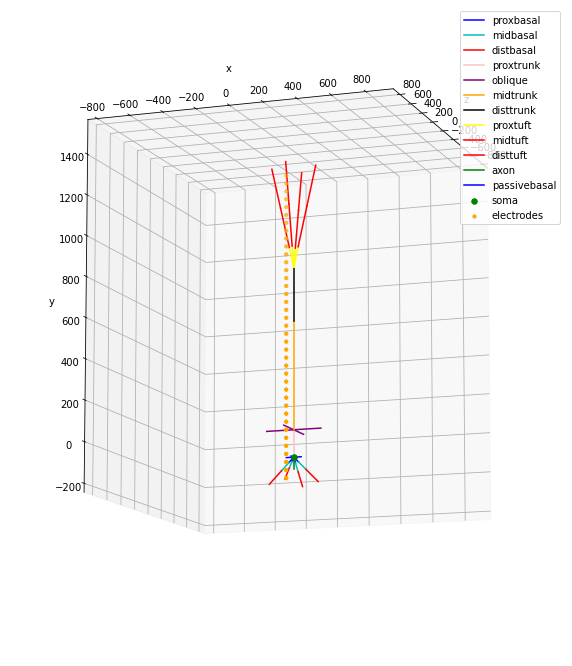

(<Figure size 720x864 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7f557d9fc6d0>)

In [24]:
from utils.plot_results import plot_LFP_traces,plot_LFP_heatmap
from utils.plot_morphology import plot_morphology 
plot_morphology(sim,electrodes=elec_pos,elev=-10, azim=20, figsize=(10,12), clr = ['g', 'b', 'c', 'red', 'pink', 'purple','orange','black','yellow','red','red','green','blue'])

In [25]:
plt.figure(figsize=(3,10))
ax = plt.plot(AllSegXCoord, AllSegYCoord,'.',color='k',markersize=6)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.plot(AllSegXCoord[135], 
         AllSegYCoord[135],
         'r*')
plt.plot(AllSegXCoord[0], 
         AllSegYCoord[0],
         'b*')
plt.plot(AllSegXCoord[70], 
         AllSegYCoord[70],
          'm*')
# plt.plot(segs.loc[segs.segmentID==1500,'Coord X'], 
#          segs.loc[segs.segmentID==1500,'Coord Y'],
#          'g*')
# plt.plot(segs.loc[segs.segmentID==680,'Coord X'], 
#          segs.loc[segs.segmentID==680,'Coord Y'],
#          '*',color='orange')
# plt.plot(segs.loc[segs.segmentID==482,'Coord X'], 
#          segs.loc[segs.segmentID==482,'Coord Y'],
#          '*',color='grey')
# plt.savefig('fig1A.svg')

NameError: ignored

In [ ]:
# v_dend = dend_v.as_numpy()

# plt.figure(figsize=(4,4))
# s1 = 323548+1500. #np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
# plt.plot(np.arange(0,5200.1,.1),v_dend[0],color='b')
# #1433413, 1161455
# plt.hlines(-55,600,4600)
# plt.hlines(-71,0,5200, color = 'grey', linestyle = 'dashed')
# #plt.hlines(-40,0,4000, color = 'grey', linestyle = 'dashed')
# plt.text(1000,-54,'1s')
# plt.vlines(600,-55,-60)
# plt.text(800,-58,'10 mV')
# plt.box(False)
# plt.xticks([])
# plt.yticks([])
# plt.savefig('-50pa curve.png')

In [ ]:
v_dend = dend_v.as_numpy()


#segments 85 - 91 axon 

plt.figure(figsize=(20,4))
s1 = 323548+1500. #np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,((tstop)+.1),.1),v_dend[85],color='b')
#1433413, 1161455
plt.hlines(-80,600,4600)
plt.hlines(-65,0,5200, color = 'grey', linestyle = 'dashed')
#plt.hlines(-40,0,4000, color = 'grey', linestyle = 'dashed')
plt.text(1000,-86,'1s')
plt.vlines(600,-55,-60)
plt.text(800,-58,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
#plt.savefig('300pa curve.png')

In [ ]:


plt.figure(figsize=(25,4))
s1 = 323548+1500. #np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,((tstop*1)+.1),.1),v_dend[70],color='m')
#1433413, 1161455
plt.hlines(-60,170,200)
plt.hlines(-65,0,4000, color = 'grey', linestyle = 'dashed')
plt.hlines(-40,0,4000, color = 'grey', linestyle = 'dashed')
plt.text(170,-65,'10 ms')
plt.vlines(170,-60,-50)
plt.text(140,-55,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])

In [ ]:
v_dend = dend_v.as_numpy()

plt.figure(figsize=(10,4))
s1 = 323548+1500. #np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,((tstop)+.1),.1),v_dend[0],color='b')
#1433413, 1161455
plt.hlines(-60,170,200)
plt.hlines(-65,0,4000, color = 'grey', linestyle = 'dashed')
plt.hlines(-35,0,4000, color = 'grey', linestyle = 'dashed')
plt.text(170,-65,'10 ms')
plt.vlines(170,-60,-50)
plt.text(140,-55,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])

The value after the section indicates the poroportional distance along the segment. 1 being distal from the soma and 0 being proximal to the soma.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

#v_dend = dend_v.as_numpy()

plt.figure(figsize=(20,14))
for i in range(v_dend.shape[0]):
    plt.plot(t,v_dend[i,:])
    plt.title(Vrecord[i], loc='center')
    plt.ylabel('Vm')
    plt.xlabel('ms')
plt.show()